In [21]:
def ComputeFluxRatio(Rp, sep_in_orbit_plane, alpha, Ag = 0.5):
    ''' For a single planet compute planet/star flux ratio using Cahoy 2010 eqn 1
    and https://ui.adsabs.harvard.edu/abs/2017ApJ...844...89C/abstract
    
    Args:
        Rp (astropy units object): planet radius
        sep (astropy units object): planet-star separation
        alpha (flt): phase angle in degrees
        Ag (flt): geometric albedo

    Returns:
        flt: planet-star contrast
    '''
    alpha = np.radians(alpha)
    angleterm = (np.sin(alpha) + (np.pi - alpha)*np.cos(alpha)) / np.pi
    Rp = Rp.to(u.km)
    sep = sep.to(u.km)
    C = Ag * ((Rp / sep_in_orbit_plane)**2) * angleterm
    return C


def GetPhaseAngle(MeanAnom, ecc, inc, argp):
    ''' Function for returning observed phase angle given orbital elements
    Args:
        MeanAnom (flt): Mean anomly in radians, where MeanAnom = orbit fraction*2pi, or M=2pi * time/Period
        ecc (flt): eccentricity, defined on [0,1)
        inc (flt): inclination in degrees, where inc = 90 is edge on, inc = 0 or 180 is face on orbit
        argp (flt): argument of periastron in degrees, defined on [0,360)
        
    Returns:
        flt: phase angle in degrees
    Written by Logan Pearce, 2023
    '''
    import numpy as np
    inc = np.radians(inc)
    argp = np.radians(argp)
    EccAnom = danby_solve(eccentricity_anomaly, MeanAnom, ecc, 0.001, maxnum=50)
    TrueAnom = 2*np.arctan( np.sqrt( (1+ecc)/(1-ecc) ) * np.tan(EccAnom/2) )
    Alpha = np.arccos( np.sin(inc) * np.sin(TrueAnom + argp) )
    return np.degrees(Alpha)

/var/folders/tm/1xdh6wyn1qv7mhy_c10d5c_w0000gn/T/ipykernel_56200/3304897437.py:108: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


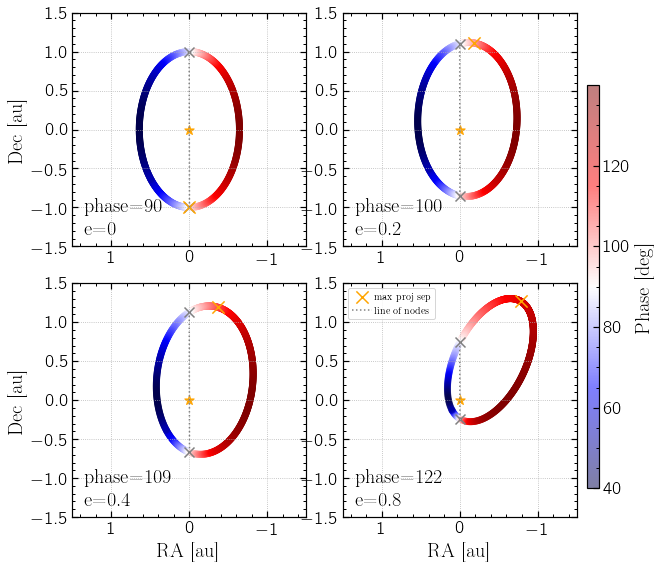

In [80]:
from myastrotools.reflectx_supplemental import (keplerian_to_cartesian, keplersconstant, danby_solve, 
                                                    eccentricity_anomaly,
                                                   Get_LOD)
def ComputeThings(M1,M2,sma,ecc,inc,argp,lon):
    
    kep = keplersconstant(M1,M2)

    xs = []
    ys = []
    zs = []
    truexs = []
    trueys = []
    truezs = []
    alphas = []
    n=1000
    meananom = np.linspace(0,2*np.pi,n)

    for j in range(len(meananom)):
        EccAnom, pos_planeoforbit, pos, vel, acc = keplerian_to_cartesian(sma, ecc, inc, argp, lon, 
                                                                         meananom[j], kep, 
                                                                         solvefunc = danby_solve, 
                                                                         return_orbit_plane = True,
                                                                         return_ecc_anom = True)
        xs.append(pos[0].value)
        ys.append(pos[1].value)
        zs.append(pos[2].value)
        truexs.append(pos_planeoforbit[0].value)
        trueys.append(pos_planeoforbit[1].value)
        truezs.append(pos_planeoforbit[2].value)

        alpha = GetPhaseAngle(meananom[j], ecc, inc, argp)
        alphas.append(alpha)


    xs = np.array(xs)
    ys = np.array(ys)
    zs = np.array(zs)
    truexs = np.array(truexs)
    trueys = np.array(trueys)
    truezs = np.array(truezs)
    alphas = np.array(alphas)

    nodes_idx = np.where(np.sign(zs[:-1]) != np.sign(zs[1:]))[0] + 1


    sep_planeoforbit = np.sqrt(truexs**2 + trueys**2)
    sep_planeofsky = np.sqrt(xs**2 + ys**2)
    apastron = np.max(sep_planeoforbit)
    maxprojsep = np.max(sep_planeofsky)
    return xs, ys, zs, truexs, trueys, truezs, nodes_idx, sep_planeoforbit, sep_planeofsky, apastron, maxprojsep, alphas

M1 = 1*u.Msun
M2 = 1*u.Mjup
sma = 1*u.au
ecc = 0.4
inc = 50 # deg
argp = 130 # deg
lon = 0

eccs = [0,0.2,0.4,0.8]

%matplotlib inline
# plt.subplot(211)
# plt.plot(trueys,truexs)
# ind = np.where(sep_planeoforbit == apastron)[0]
# plt.scatter(trueys[ind],truexs[ind])
# plt.xlim(-2,2)
# plt.ylim(-2,2)
# plt.scatter(0,0,marker='*',color='orange',s=100)
# plt.gca().set_aspect('equal')
# plt.subplot(212)

import matplotlib.cm as cm
fig, axs = plt.subplots(2, 2, figsize=(8,8))
for ax, ecc in zip(axs.flat, eccs):
    xs, ys, zs, truexs, trueys, truezs, nodes_idx, sep_planeoforbit, sep_planeofsky, apastron, maxprojsep, alphas = ComputeThings(M1,M2,sma,ecc,inc,argp,lon)
    ps = ax.scatter(ys,xs, c=alphas, cmap="seismic", alpha=0.5)
    #ind = np.where(sep_planeoforbit == apastron)[0]
    #ax.scatter(ys[ind],xs[ind], marker='x',s=150, color='turquoise', label='apastron')
    ax.scatter(ys[nodes_idx],xs[nodes_idx], marker='x',color='grey', s=100)
    
    maxprojsepind = np.where(sep_planeofsky == maxprojsep)[0]
    ax.scatter(ys[maxprojsepind],xs[maxprojsepind], marker='x',s=150, color='orange', label='max proj sep')
    ax.annotate('phase='+str(int(alphas[maxprojsepind])),xy = (0.05,0.15), fontsize= 20, xycoords='axes fraction')
    
    ax.plot(ys[nodes_idx],xs[nodes_idx], color='grey', ls=':', label='line of nodes')
    ax.scatter(0,0,marker='*',color='orange',s=100)
    
    if ecc == eccs[2] or ecc == eccs[3]:
        ax.set_xlabel('RA [au]')
    if ecc == eccs[2] or ecc == eccs[0]:
        ax.set_ylabel('Dec [au]')
    ax.set_xlim(-1.5,1.5)
    ax.set_ylim(-1.5,1.5)
    ax.invert_xaxis()
    ax.set_aspect('equal')
    ax.grid(ls=':')
    ax.annotate('e='+str(ecc),xy = (0.05,0.05), fontsize= 20, xycoords='axes fraction')
    if ecc == eccs[3]:
        ax.legend()
    if ecc == eccs[0]:
        cbar_ax = fig.add_axes([1, 0.15, 0.02, 0.7])
        fig.colorbar(ps, cax=cbar_ax)
        cbar_ax.set_ylabel('Phase [deg]')
    
# cbar = plt.colorbar()
# cbar.ax.set_ylabel('Phase [deg]')
plt.tight_layout()
plt.savefig('phase-at-max-sep-vs-ecc.png')

(array([  2.,   2.,   8.,  26.,  49., 105.,  33.,  16.,  10.,   5.]),
 array([ 33.29642721,  44.02219659,  54.74796598,  65.47373537,
         76.19950475,  86.92527414,  97.65104352, 108.37681291,
        119.10258229, 129.82835168, 140.55412106]),
 <BarContainer object of 10 artists>)

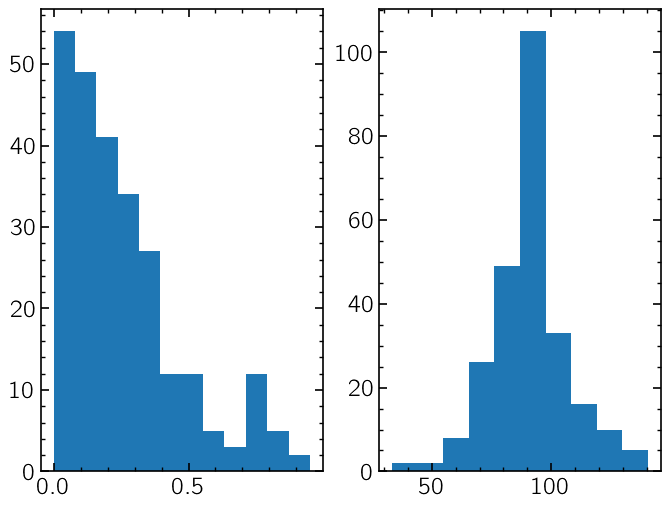

In [118]:
pl = pd.read_csv('MagAO-X-target-list.csv')
%matplotlib inline
plt.subplot(121)
plt.hist(pl['pl_orbeccen'], bins='fd')
plt.subplot(122)
plt.hist(pl['PhaseAtMaxProj'])

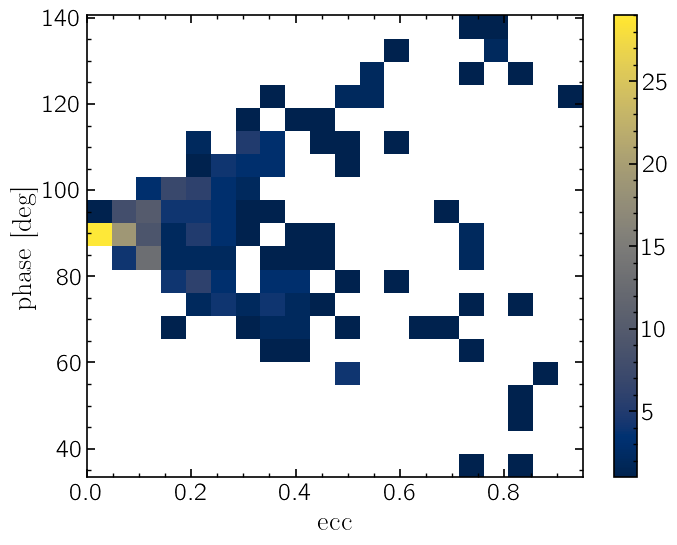

In [120]:
%matplotlib inline
plt.hist2d(pl['pl_orbeccen'],pl['PhaseAtMaxProj'],bins=20,cmin=1)
plt.colorbar()
plt.xlabel('ecc')
plt.ylabel('phase [deg]')
plt.show()